In [ ]:
import numpy as np
import pandas
import time
import random
import gc
import re
import itertools
import pickle
from ipywidgets import IntProgress
from IPython.display import display
from collections import defaultdict 
from textdistance import Editex
from nltk import word_tokenize, pos_tag, PorterStemmer
from nltk.data import load
from nltk.corpus import cmudict
from sklearn.base import TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
with open('rhymes.p', 'rb') as f: #rhyme word dictionary tailored to data set, created beforehand
    rhymes = pickle.load(f)

## Pre-processing

In [ ]:
df = pandas.read_csv('lyrics.csv', sep=',')

In [ ]:
df = df.drop(['index', 'year', 'song', 'artist'], axis=1)

df = df[df['genre'] != 'Not Available']
df = df[df['genre'] != 'Other']
#Too few samples:
df = df[df['genre'] != 'Electronic']
df = df[df['genre'] != 'Jazz']
df = df[df['genre'] != 'Folk']

#Too few samples / fit in another genre
df.loc[df['genre']=='R&B', 'genre'] = 'Hip-Hop'
df.loc[df['genre']=='Indie', 'genre'] = 'Rock'

#drop empty lyrics / Nones and NaNs
df = df[df.lyrics != '']
df = df.dropna(how='any')

#randomly drop a large portion of Rock lyrics because they are over-represented and will skew classification
remove_n = len(df[df['genre'] == 'Rock'])-38000
drop_indices = list(np.random.choice(df.index[df['genre']=='Rock'], remove_n, replace=False))
df = df.drop(drop_indices)

In [ ]:
#remove [Text] such as [Chorus] [Verse 1:] etc.
df['lyrics'] = df['lyrics'].str.replace('\[.*\]', '', regex=True)
df['lyrics'] = df['lyrics'].str.replace('[C|c][H|h][O|o][R|r][U|u][S|s]', '', regex=True)
df['lyrics'] = df['lyrics'].str.replace('[V|v][E|e][R|r][S|s][E|e] *[0-9]*', '', regex=True)

In [5]:
#total data set size
len(df)

144863

In [6]:
#genre distribution
[len(df[df.genre==l]) for l in df.genre.unique()]

[40466, 28251, 38000, 23759, 14387]

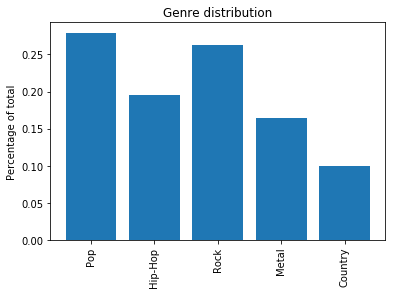

In [246]:
plt.bar(df.genre.unique(), [len(df[df.genre==l])/len(df) for l in df.genre.unique()])
plt.xticks(rotation='vertical')
plt.title("Genre distribution")
plt.ylabel("Percentage of total");

In [ ]:
change_labels = {'Pop':1,'Hip-Hop':2,'Rock':3,'Metal':4,'Country':5}
df_x = np.array(df['lyrics'])
df_y = np.array(df['genre'])
df_y = np.array([change_labels[x] for x in df_y]) # numeric value for classification

In [245]:
#majority classifier would obtain 27.9% accuracy
print(len(df[df['genre']=='Pop'])/len(df))

0.2793397900084908

In [ ]:
#split data in train and test sets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=101)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [ ]:
#Following two cells create the dictionary of rhyme words for the collection, which is loaded as a pickle file in 
#subsequent runs

'''
from rhyme import getRhymes as rhyme #from https://github.com/qpwo/python-rhyme

all_unique_words = set([])
total = 0
for i in range(len(df_x)):
    doc = re.sub('[^\w\s]','',df_x[i].lower())
    doc = re.sub('\s+',' ',doc)
    all_unique_words.update(doc.split())
    total+=len(doc.split())
''';

In [ ]:
'''
rhymes = {}
all_unique_words = list(all_unique_words)
start = time.time()
for i in range(len(all_unique_words)):
    rhymes[all_unique_words[i]] = rhyme(all_unique_words[i])
    if i%int(len(all_unique_words)/20)==0:
        print(int(i/len(all_unique_words)*100),"%", time.time()-start)

with open('rhymes.p', 'wb') as f:
    pickle.dump(rhymes, f)
''';

## Vectorizing & features

In [ ]:
#Stemming the data (not used in final version)

def stemData(data):
    print("stemming")
    stemmer = PorterStemmer()
    for i in range(len(data)):
        data[i] = ' '.join([stemmer.stem(x) for x in word_tokenize(re.sub('[^\w\s]', '', data[i]))])
        if(i%int(len(data)/10)==0):
            print(i/float(len(data))*100, "%")
    return data

stemTransform = FunctionTransformer(stemData, validate=False)

##### Rhyme features

In [ ]:
def RhymeVectorizer(data):
    print('Rhyme')
    features = np.zeros((len(data),4), dtype=float)
    
    #progress bar
    progress = IntProgress(min=0, max=len(data))
    display(progress)
    
    for i in range(len(data)):
        progress.value+=1
        
        #removes punctuation
        doc = re.sub('[^\w\s]','',data[i].lower())
        
        #last word of each line
        end_words = [re.sub('[\W]','',line.split()[-1]).lower() if len(line.split())>0 else '' for line in \
                     doc.split('\n')]
        
        #rhymes dictionary for this document to eliminate the need for many searches in all rhymes, just in case
        doc_rhymes = dict([(x, rhymes[x]) if x in rhymes else (x,[]) for x in re.compile('[\s]+').split(doc)])
        
        #end of line rhymes
        for j in range(len(end_words)-1): 
            try:
                features[i][0] += 1 if end_words[j+1] in doc_rhymes[end_words[j]] else 0 #AA
            except: #key error on '', will only try this once
                continue
            try: 
                features[i][1] += 1 if end_words[j+2] in doc_rhymes[end_words[j]] else 0 #AxA
            except: #last word index will be out of bounds (+2), skip these features
                continue
                
        #within line rhyme
        for line in doc.split('\n'): 
            for j in range(len(line.split())): #word 1 rhymes with...?
                for k in range(j, len(line.split())): #word 2
                    features[i][2]+=1/len(line.split()) if line.split()[k] in doc_rhymes[line.split()[j]] else 0
        
        #normalize
        for f in range(len(features[i])):
            features[i][f]/=len(doc.split('\n'))
        
    return features

#Create transformer from function, used in the pipeline
Rhymefeatures = FunctionTransformer(RhymeVectorizer, validate=False)

##### Part of speech features

In [ ]:
#unused feature extractor for POS tags

'''
def POSvectorizer1(data):
    features = np.zeros((len(data),8), dtype=float)
    print("POS")
    for i in range(len(data)):
        data[i] = re.sub('[^\w\s]','',data[i].lower())
        doc = [x for _,x in pos_tag(word_tokenize(data[i]))]        
        N = len(data[i])
        if(N>0):
            features[i][0] = sum([doc.count(x) for x in 'NN NNP NNS NNPS'.split()])/N #nouns
            features[i][1] = sum([doc.count(x) for x in 'VB VBD VBG VBN VBP VBZ'.split()])/N #verbs
            features[i][2] = sum([doc.count(x) for x in 'PRP PRP$ WP WP$'.split()])/N #pronouns
            features[i][3] = sum([doc.count(x) for x in 'IN'.split()])/N #prepositions
            features[i][4] = sum([doc.count(x) for x in 'RB RBR RBS WRB'.split()])/N #adverbs
            features[i][5] = doc.count('DT')/N #determiners
            features[i][6] = doc.count('MD')/N #modals
            features[i][7] = sum([doc.count(x) for x in 'JJ JJR JJS'.split()])/N #adjectives
            
        if(i%int(len(data)/10)==0):
            print(int(i/float(len(data))*100), "%")
    return features

POSfeatures1 = FunctionTransformer(POSvectorizer1, validate=False)
''';

In [ ]:
#unused feature extractor for POS tags (groups variation of tags together)

'''
def POSvectorizer2(data):
    print("POS")
    
    progress = IntProgress(0,len(data))
    display(progress)
    
    for i in range(len(data)):
        progress.value+=1
        data[i] = re.sub('[^\w\s]','',data[i].lower())
        doc = ' '.join([x for _,x in pos_tag(word_tokenize(data[i]))])  
        doc = re.sub('NN|NNP|NNS|NNPS','NOUN',doc)
        doc = re.sub('VB|VBD|VBG|VBN|VBP|VBZ','VERB',doc)
        doc = re.sub('PRP|PRP\$|WP|WP\$','PRONOUN',doc)
        doc = re.sub('IN','PREP',doc)
        doc = re.sub('RB|RBR|RBS|WRB','ADVERB',doc)
        data[i] = re.sub('JJ|JJR|JJS','ADJECTIVE',doc)
            
    
    return data

getPOS = FunctionTransformer(POSvectorizer2, validate=False)
''';

In [ ]:
def POSvectorizer3(data):
    '''
    returns the POS tags for all the words in the lyrics
    '''
    print("POS")
    
    progress = IntProgress(min=0 , max=len(data))
    display(progress)
    
    for i in range(len(data)):
        progress.value += 1
        data[i] = data[i].lower()
        data[i] = re.sub('[^\w\s]','',data[i])
        data[i] = ' '.join([x for _,x in pos_tag(word_tokenize(data[i]))])  
           
    return data

getPOS2 = FunctionTransformer(POSvectorizer3, validate=False)

##### Text characteristics features

In [ ]:
#number of syllables per word (words from nltk)
prondict = cmudict.dict()

def numsyllables(word): #inspiration: https://datawarrior.wordpress.com/2016/03/29/flesch-kincaid-readability-measure/
    try:
        return sum([1 if x[-1].isdigit() else 0 for x in prondict[word.lower()][0]])
    except KeyError:
        return 1

In [ ]:
def StatsVectorizer(data):
    print("Stats")
    features = np.zeros((len(data),14), dtype=float)
    avg_nr_words = float(np.mean([len(text.split()) for text in data]))
        
    progress = IntProgress(min=0, max=len(data))
    display(progress)
    
    for i in range(len(data)):
        progress.value+=1
        whitespace = re.compile('\s')
        nr_words = len(whitespace.split(data[i]))
        if(nr_words<2):
            continue
        features[i][0] = data[i].count('.')/nr_words
        features[i][1] = data[i].count('?')/nr_words
        features[i][2] = data[i].count(',')/nr_words
        features[i][3] = (data[i].count('"')+data[i].count('\''))/nr_words
        features[i][4] = data[i].count(':')/nr_words
        features[i][5] = data[i].count('-')/nr_words
        features[i][6] = data[i].count('\n')/nr_words
        features[i][7] = nr_words/avg_nr_words #nr words / mean
        features[i][8] = np.mean([len(x.split()) for x in data[i].split('\n')]) #mean nr words per line
        features[i][9] = len(set(whitespace.split(data[i])))/nr_words #unique words fraction
        features[i][10] = np.mean([len(set(whitespace.split(x)))/(len(whitespace.split(x))) if len(whitespace.split(x))>0 else 0 for x in data[i].split('\n')]) #unique words per line
        features[i][11] = np.mean([len(x) for x in whitespace.split(data[i])]) #word length
        features[i][12] = sum(1 for c in data[i] if c.isdigit())/nr_words
        features[i][13] = sum([numsyllables(word) for word in whitespace.split(re.sub('[^\w\s]','',data[i]))])/nr_words #avg nr syllables

    return features

Statsfeatures = FunctionTransformer(StatsVectorizer, validate=False)

In [ ]:
vectorizerTFIDF = TfidfVectorizer(stop_words='english', sublinear_tf=True, max_df=0.5, min_df=2, ngram_range=(1,1))
vectorizerPOS = TfidfVectorizer(vocabulary=list(load('help/tagsets/upenn_tagset.pickle').keys()), use_idf=False, lowercase=False)

In [ ]:
selector10 = SelectPercentile(percentile=10) #select best k% of features
selector40 = SelectPercentile(percentile=40)

In [ ]:
tfidf = Pipeline([
                         #('stemmer', stemTransform), #stemming
                         ('vectorize', vectorizerTFIDF), #vectorization
                         ('selection', selector10) #feature selection
])

In [ ]:
pos = Pipeline([
                    ('getTags', getPOS2), #get POS tags
                    ('vectorize', vectorizerPOS), #vectorization
                    ('selector', selector40) #feature selection
])

In [ ]:
features = FeatureUnion([
                        ('vectorizer', tfidf),
                        ('stats', Statsfeatures), 
                        ('Rhymefeatures', Rhymefeatures),
                        ('POS', pos),
                        ])

## Classification

In [ ]:
svc = SVC()
mnb = MultinomialNB()
tree = DecisionTreeClassifier(max_depth=25, min_samples_leaf=500)

## Pipeline

In [ ]:
pipeline = Pipeline([
    ('features', features), #extract features
    ('classifier', mnb), #classify
])

In [ ]:
pipeline.fit(x_train, y_train)

In [ ]:
predictions_p = pipeline.predict_proba(x_test)

In [ ]:
def threshold_predictions(probabilities, threshold=0.4):
    '''
    Takes the probabilities for each class and transforms them to predictions, taking into account the 
    classification threshold
    '''
    preds = np.zeros(len(probabilities))
    
    for index, prob in enumerate(probabilities):
        if max(prob)<threshold:
            preds[index] = -1
        else:
            preds[index] = list(prob).index(max(prob))+1
        
    return preds

predictions = threshold_predictions(predictions_p, 0)

## Evaluation

In [270]:
labels = np.array(y_test).astype(int)

correct = 0
for i in range(len(predictions)):
    if(predictions[i]==labels[i]):
        correct+=1
        

print(correct/sum([1 if x != -1 else 0 for x in predictions]), '% accuracy')
print(100-list(predictions).count(-1)/len(predictions)*100,'% classified')

0.6030787284713354 % accuracy
100.0 % classified


In [ ]:
'''
Trade-off between threshold and accuracy
'''
percent_classified = np.zeros(100)
accuracy = np.zeros(100)

for index, p in enumerate(np.linspace(0.01,1,100)):
    predicted = threshold_predictions(predictions_p, p)
    length = len(predicted)
    
    percent_classified[index] = 100-list(predicted).count(-1)/length*100
    
    correct = 0
    for i in range(len(predicted)):
        if(predicted[i]==labels[i]):
            correct+=1
            
    nr_classified = sum([1 if x != -1 else 0 for x in predicted])
    
    accuracy[index] = correct/nr_classified*100 if nr_classified != 0 else 100

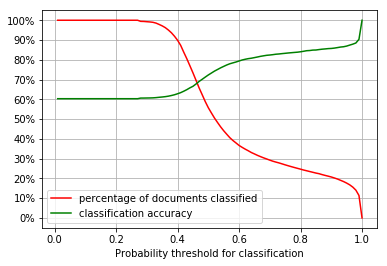

In [275]:
x = np.linspace(0.01,1,100)
plt.plot(x, percent_classified, 'r-')
plt.plot(x, accuracy, 'g-')
plt.xlabel("Probability threshold for classification")
plt.yticks(np.linspace(0,100,11), [str(x)[:-2]+"%" for x in np.linspace(0,100,11)])
plt.legend(['percentage of documents classified', 'classification accuracy'])
plt.grid();
#plt.title("Classification threshold trade-off");

In [ ]:
threshold = 0

predicted = threshold_predictions(predictions_p, threshold=threshold)
labels_thresh = [x for i,x in enumerate(labels) if predicted[i]>0]
pred_thresh = [x for x in predicted if x>0]

## Confusion Matrix

In [ ]:
np.set_printoptions(threshold=np.nan)


#function from scikit-learn example
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


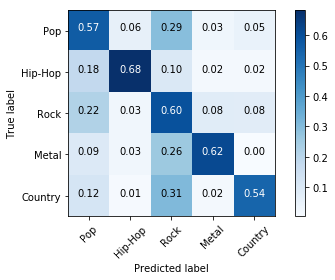

In [274]:
cm = confusion_matrix(labels_thresh, pred_thresh);
plot_confusion_matrix(cm, classes=df.genre.unique(), normalize=True);